In [1]:
# Load data ke dalam data frame 
import pandas as pd

# spesifikasi encoding diperlukan karena data tidak menggunakan UTF-8
df = pd.read_csv('200 data dilabeli pak fajar dan mhs.csv', encoding='latin-1') 

df.head()

,Review,Sentimen
0,Kecewa banget. Saya pesan yang free pouch tapi...,Negatif
1,"Kali ini pengemasan tidak safe,, sepertinya tu...",Negatif
2,paket datangnya barang sudah pecah dan sy retu...,Negatif
3,"ga ada sabun nya, ga sesuai deskripsi",Negatif
4,ga sesuai harapan,Negatif


In [2]:
# Cek jumlah data per kelas
print(df['Sentimen'].value_counts())
print('\n')

# Cek kelengkapan data
print(df.info())
print('\n')

# Cek statistik deskriptif
print(df.describe())

Positif    81
Netral     67
Negatif    52
Name: Sentimen, dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Review    200 non-null    object
 1   Sentimen  200 non-null    object
dtypes: object(2)
memory usage: 3.2+ KB
None


                                                   Review Sentimen
count                                                 200      200
unique                                                187        3
top     Sudah berkali-kali beli di toko official ini d...  Positif
freq                                                    2       81


In [3]:
# Data untuk label
new_labels = {
    'Negatif' : 0,
    'Netral' : 1,
    'Positif' : 2
}

# Encode label (mengubah label dari spam dan ham menjadi 1 dan 0)
df['Sentimen'] = df['Sentimen'].map(new_labels)

# Cek data teratas
df.head()

,Review,Sentimen
0,Kecewa banget. Saya pesan yang free pouch tapi...,0
1,"Kali ini pengemasan tidak safe,, sepertinya tu...",0
2,paket datangnya barang sudah pecah dan sy retu...,0
3,"ga ada sabun nya, ga sesuai deskripsi",0
4,ga sesuai harapan,0


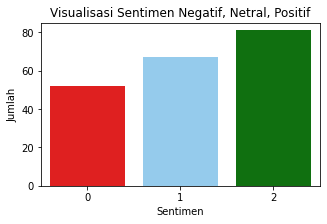

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# visualisasi sentimen positif, netral, dan negatif
plt.figure(figsize=(5, 3))
sns.countplot(data=df, x='Sentimen', palette={0: 'red', 1: 'lightskyblue', 2: 'green'})
plt.title('Visualisasi Sentimen Negatif, Netral, Positif')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.show()

In [5]:
# Memisahkan fitur dengan label
X = df['Review'].values
y = df['Sentimen'].values

In [6]:
# Ekstraksi fitur
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Inisialisasi model
mnb = MultinomialNB()

# Membuat objek StratifiedKFold untuk 10-fold cross-validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inisialisasi TfidfVectorizer
bow = TfidfVectorizer(max_features=510)

# List untuk menyimpan prediksi dan label sebenarnya dari setiap lipatan
all_predictions = []
all_true_labels = []

# Loop melalui setiap lipatan (fold) dalam cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]  # Data latih dan uji
    y_train, y_test = y[train_index], y[test_index]  # Label data latih dan uji

    # Transformasi seluruh data menggunakan TfidfVectorizer
    X_train_transform = bow.fit_transform(X_train)
    X_test_transform = bow.transform(X_test)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_transform, y_train)

    # Melatih model klasifikasi pada data latih
    mnb.fit(X_train_resampled, y_train_resampled)

    # Membuat prediksi pada data uji
    predictions = mnb.predict(X_test_transform)

    # Menambahkan prediksi dan label sebenarnya ke dalam list
    all_predictions.extend(predictions)
    all_true_labels.extend(y_test)

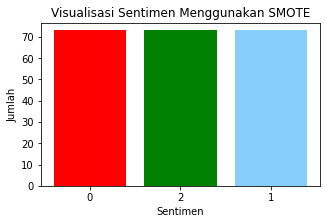

In [7]:
# visualisasi hasil resampling
# Convert NumPy array to pandas Series
y_train_resampled_series = pd.Series(y_train_resampled)

# Visualisasi hasil resampling
sentimen_counts = y_train_resampled_series.value_counts()

plt.figure(figsize=(5, 3))
plt.bar(sentimen_counts.index, sentimen_counts.values, color=['red', 'lightskyblue', 'green'])
plt.title('Visualisasi Sentimen Menggunakan SMOTE')
plt.xlabel('Sentimen')
plt.ylabel('Jumlah')
plt.xticks(sentimen_counts.index, ['0', '1', '2'])
plt.show()

In [8]:
# Hitung metrik evaluasi
accuracy = accuracy_score(all_true_labels, all_predictions)
precision = precision_score(all_true_labels, all_predictions, average='weighted')
recall = recall_score(all_true_labels, all_predictions, average='weighted')
f1 = f1_score(all_true_labels, all_predictions, average='weighted')

# Print hasil
print("Overall accuracy:", accuracy)
print("Overall precision:", precision)
print("Overall recall:", recall)
print("Overall F1-score:", f1)

print(f'Confusion Matrix : \n {confusion_matrix(all_true_labels, all_predictions)}')
print('-----------------------------------------------------\n')
print(classification_report(all_true_labels, all_predictions, zero_division=0))

Overall accuracy: 0.6
Overall precision: 0.5982049448008786
Overall recall: 0.6
Overall F1-score: 0.5891704347826087
Confusion Matrix : 
 [[44  3  5]
 [13 28 26]
 [16 17 48]]
-----------------------------------------------------

              precision    recall  f1-score   support

           0       0.60      0.85      0.70        52
           1       0.58      0.42      0.49        67
           2       0.61      0.59      0.60        81

    accuracy                           0.60       200
   macro avg       0.60      0.62      0.60       200
weighted avg       0.60      0.60      0.59       200



In [11]:
new_text = input("\nMasukkan teks baru: ")
new_text_vec = bow.transform([new_text])
predicted_sentimen = mnb.predict(new_text_vec)

if predicted_sentimen[0] == 0:
    sentiment_label = "negatif"
elif predicted_sentimen[0] == 1:
    sentiment_label = "netral"
elif predicted_sentimen[0] == 2:
    sentiment_label = "positif"

print("Hasil Analisis Sentimen untuk Teks Baru : ", sentiment_label)

Hasil Analisis Sentimen untuk Teks Baru :  negatif
